In [1]:
import feets.preprocess
from scipy import stats
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib
import feets
from ipykernel import kernelapp as app
import os



script_dir = os.path.dirname('Results/')
results_dir = os.path.join(script_dir, 'Images/')

if not os.path.isdir(results_dir):
    os.makedirs(results_dir)

In [2]:
url = "https://raw.githubusercontent.com/MachineLearningUniandes/MANTRA/master/data/lightcurves/transient_lightcurves.csv"
url1 = 'https://raw.githubusercontent.com/MachineLearningUniandes/MANTRA/master/data/lightcurves/transient_labels.csv'
url2 = 'https://raw.githubusercontent.com/MachineLearningUniandes/MANTRA/master/data/lightcurves/transient_info.txt'
transient_lc = pd.read_csv(url)
transient_labels = pd.read_csv(url1)
transient_info = pd.read_table(url2,skiprows=1,names=['CRTS_ID' ,'RA' ,'Dec','UT_Date','Mag','CSS_images' ,'SDSS',
                                                      'Others' ,'Followed' ,'Last','LC','FC','Classification'])

# 1. Isolation forest (Machine Learning)

In [3]:
import seaborn as sns
from sklearn.ensemble import IsolationForest

In [4]:
# Reading in the feature.csv data
ft_data = pd.read_csv('features.csv',skiprows=1,names= ['Amplitude', 'AndersonDarling', 'Autocor_length', 'Beyond1Std',
                                                  'CAR_sigma', 'Con', 'Eta_e', 'Freq1_harmonics_rel_phase_1',
                                                  'LinearTrend', 'MaxSlope', 'Mean', 'Period_fit', 
                                                  'SlottedA_length','SmallKurtosis', 'StructureFunction_index_21'
                                                  ,'ID','Class'])


ft_data.head()

,Amplitude,AndersonDarling,Autocor_length,Beyond1Std,CAR_sigma,Con,Eta_e,Freq1_harmonics_rel_phase_1,LinearTrend,MaxSlope,Mean,Period_fit,SlottedA_length,SmallKurtosis,StructureFunction_index_21,ID,Class
0,1.50475,1.000000,2.0,0.411765,10.0,0.015152,1.639083e+07,0.133163,-0.000216,310.686183,20.125262,1.000000,6.0,10.438348,1.742156,TranID1209210010044118805,Flare
1,1.53220,1.000000,8.0,0.345946,10.0,0.032787,2.411989e+06,-0.209898,-0.000333,317.453004,19.331475,0.000000,1.0,3.227174,1.723731,TranID1310250040014131234,SN
2,1.24740,0.999302,2.0,0.414634,10.0,0.000000,8.020303e+06,1.009082,0.000009,123.993913,20.123456,0.970337,17.0,0.000310,1.731060,TranID1011080040044131101,SN
3,1.23785,1.000000,6.0,0.410000,10.0,0.061224,4.823456e+06,-0.119399,-0.000227,146.497039,19.704732,0.003795,2.0,1.244926,1.677341,TranID1310250070034110542,SN
4,1.36500,1.000000,30.0,0.371528,10.0,0.073427,2.173539e+05,0.397704,-0.000552,210.703834,18.261774,0.000000,3.0,1.919426,1.403380,TranID1201030070034134767,Blazar


### 1.1 Data preprocessing

In [5]:
params = ['Amplitude', 'AndersonDarling', 'Autocor_length', 'Beyond1Std',
                                                  'CAR_sigma', 'Con', 'Eta_e', 'Freq1_harmonics_rel_phase_1',
                                                  'LinearTrend', 'MaxSlope', 'Mean', 
                                                  'SlottedA_length','SmallKurtosis', 'StructureFunction_index_21'
                                                  ]

X = ft_data[params]

### 1.2 Runnning iforest and plotting the results

In [6]:
model=IsolationForest(n_estimators=400, max_samples='auto',max_features=1.0)
x=model.fit(X)



pred_cls = []
# Predicting the anomalies
ft_data['iforest'] = pd.Series(model.predict(X))
ft_data['iforest_Counts'] = ft_data['iforest'].map({1:0,-1:1})
# Counting the detected anomalies
print(ft_data['iforest'].value_counts())

# Analysing the predicted anomalies
pred=ft_data.loc[ft_data['iforest'] == -1]
for i in range(len(pred.ID)):
    
    
#     plt.figure(figsize=(16,4))
#     plt.xlabel('MJD')
#     plt.ylabel('Mag')
    lc = transient_lc[transient_lc['ID']==pred.ID.iloc[i]]
    
#     print(len(lc),pred.Class.iloc[i],pred.ID.iloc[i])
    pred_cls.append(pred.Class.iloc[i])
#     plt.errorbar(lc.MJD,lc.Mag,yerr=lc.Magerr,fmt='.r',label=pred.Class.iloc[i])
#     plt.legend()
#     plt.show()

 1    2429
-1      77
Name: iforest, dtype: int64


### 1.3 Calculating the score and plotting the average score

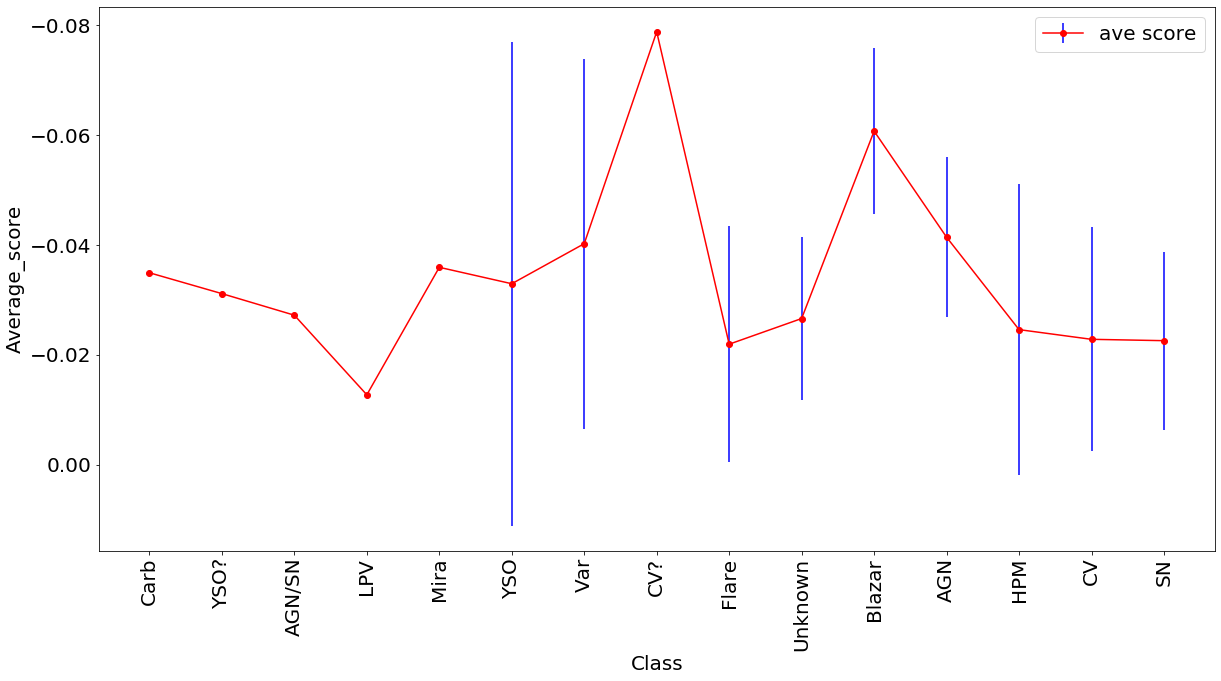

In [7]:
sklearn_score_anomalies = model.decision_function(X)

# print(sklearn_score_anomalies)

x = [i < 0 for i in sklearn_score_anomalies]

# len(ft_data[x])

anomalies_scr=sklearn_score_anomalies[x]
anomalies_cls = ft_data.Class[x]



# Getting the unique classes detected as anomalous
ML_unq_cls=np.unique(pred_cls)
x = [i < 0 for i in sklearn_score_anomalies]
anomalies_scr=sklearn_score_anomalies[x]
anomalies_cls = ft_data.Class[x]

# Getting the number of objects in each anomalous class 
# based on the transient label data
len_anm = []
for i in ML_unq_cls:
    
    lb = transient_labels[transient_labels['Classification']==i]   
    len_anm.append(len(lb))


# Sorting the classes in ascending based on the number of
# objects in each class (i.e most anomalous to least anomalous)
cls = []  
for i in range(0,max(len_anm)+1): 
    
    for j in range(len(len_anm)): 
        
        if len_anm[j] == i: 
            cls.append(ML_unq_cls[j])
            
                        
# Calculating the average and std of the anom
# scores
sstd,aave = [],[]
for j in range(len(cls)):
    scr = []
    for i in range(len(anomalies_cls)):
    
        if anomalies_cls.iloc[i] == cls[j]:
            
            scr.append(anomalies_scr[i])
            
#             print(anomalies_cls.iloc[i],anomalies_scr[i])
#     print(scr,np.std(scr))       
    std=np.std(scr)
    ave=np.average(scr)   
    sstd.append(std);aave.append(ave)
    
#     print(ave,std)
    
    

    
# Plotting the anomalous objects based on their score 
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(20,10))
df = pd.DataFrame({"id":cls, 
                   "score":aave,
                   'error':sstd
                   })
plt.errorbar(np.arange(len(df['id'])), df['score'],yerr=df['error'],fmt='-ro',ecolor='b',label='ave score')
ax = plt.gca()
ax.xaxis.set_ticks(np.arange(len(df['id'])))
ax.xaxis.set_ticklabels(df['id'], rotation=90)
plt.xlabel("Class")
plt.ylabel("Average_score")
plt.gca().invert_yaxis()
plt.legend()

plt.savefig(results_dir + 'ave_score.png',bbox_inches="tight")

plt.show()

# 2. Analysing the results (i.e Top 10) 

In [8]:
# Getting information about the top 10 detected anomalous objects

top10_anomalies = [1102081010244125249,910241150234105998,1111301120304120184,1503161230274181022,
                   1302181430344101379,1003171460404142882,812291070574110368,1504301520404124884,
                  1503211010754116328,909121011184202267]


Top10 = []
for ID in top10_anomalies:
    
    inf=transient_info.loc[transient_info['CSS_images'] == ID]
    lc = transient_lc[transient_lc['ID']=='TranID'+str(ID)]
    
    cls=transient_labels[transient_labels['Classification']=='Carb']
    

    lc2 = transient_lc[transient_lc['ID']=='TranID'+str(cls.TransientID.iloc[1])]
    
    
#     plt.figure(figsize=(16,4))
#     plt.xlabel('MJD')
#     plt.ylabel('Mag')
#     plt.errorbar(lc.MJD,lc.Mag,yerr=lc.Magerr,fmt='.r',label=inf.Classification.iloc[0])
#     plt.legend(fontsize=12)
#     plt.show()
    

### 2.1 Carbon stars


The data came in with only two carbon stars and the alogrithm managed to detect the carbon stars as anomalies. Below is are light curves of the Carbon stars. The light curves have a similar trend, the overall brightness of the star changes at some point in time and there is also a sinusiodal variation detected on the light curve of the star. 

In [9]:
# # Getting the IDs of items of the same class
# cls=transient_labels[transient_labels['Classification']=='Carb']

# plt.figure(figsize=(20,5))
# plt.subplot(121)
# lc2 = transient_lc[transient_lc['ID']=='TranID'+str(cls.TransientID.iloc[0])]
# plt.errorbar(lc2.MJD,lc2.Mag,yerr=lc2.Magerr,fmt='.r',label='Anomalous Carb Star')
# plt.xlabel('MJD')
# plt.ylabel('Mag')
# plt.legend()
# # plt.xlabel(params[n])
# # plt.ylabel('Counts')

# plt.subplot(122)
# lc2 = transient_lc[transient_lc['ID']=='TranID'+str(cls.TransientID.iloc[1])]
# plt.errorbar(lc2.MJD,lc2.Mag,yerr=lc2.Magerr,fmt='.r',label='Anomalous Carb Star')
# plt.xlabel('MJD')
# plt.ylabel('Mag')
# plt.legend()
# # plt.xlabel(params[n+1])
# # plt.ylabel('Counts')
# plt.savefig(results_dir + 'Anm_carb.png',bbox_inches="tight")
# plt.show()

### 2.2 Variable stars 

The dataset came in 49 variable stars and only a few (2 on average) were detected as anomalous. The first plot below is the best anomolous Variable star detected. In this variable star we observe a rapid increase in brightness of the object. This is different from the 5 plotted variable stars.

In [10]:
# # Getting the IDs of items of the same class
# cls=transient_labels[transient_labels['Classification']=='Var']



# print(len(cls))


# plt.rcParams.update({'font.size': 20})
# plt.figure(figsize=(30,20))


# plt.subplot(321)
# inf=transient_info.loc[transient_info['CSS_images'] == 1102081010244125249]
# lc = transient_lc[transient_lc['ID']=='TranID'+str(1102081010244125249)]
# # lc2 = transient_lc[transient_lc['ID']=='TranID'+str(cls.TransientID.iloc[0])]
# plt.errorbar(lc.MJD,lc.Mag,yerr=lc.Magerr,fmt='.r',label=inf.Classification.iloc[0]+' Anomalous')
# plt.xlabel('MJD')
# plt.ylabel('Mag')
# plt.legend()
# # plt.xlabel(params[n])
# # plt.ylabel('Counts')

# plt.subplot(322)
# lc2 = transient_lc[transient_lc['ID']=='TranID'+str(cls.TransientID.iloc[12])]
# plt.errorbar(lc2.MJD,lc2.Mag,yerr=lc2.Magerr,fmt='.r',label='Var')
# plt.xlabel('MJD')
# plt.ylabel('Mag')
# plt.legend()

# plt.subplot(323)
# lc2 = transient_lc[transient_lc['ID']=='TranID'+str(cls.TransientID.iloc[34])]
# plt.errorbar(lc2.MJD,lc2.Mag,yerr=lc2.Magerr,fmt='.r',label='Var')
# plt.xlabel('MJD')
# plt.ylabel('Mag')
# plt.legend()

# plt.subplot(324)
# lc2 = transient_lc[transient_lc['ID']=='TranID'+str(cls.TransientID.iloc[19])]
# plt.errorbar(lc2.MJD,lc2.Mag,yerr=lc2.Magerr,fmt='.r',label='Var')
# plt.xlabel('MJD')
# plt.ylabel('Mag')
# plt.legend()


# plt.subplot(325)
# lc2 = transient_lc[transient_lc['ID']=='TranID'+str(cls.TransientID.iloc[3])]
# plt.errorbar(lc2.MJD,lc2.Mag,yerr=lc2.Magerr,fmt='.r',label='Var')
# plt.xlabel('MJD')
# plt.ylabel('Mag')
# plt.legend()


# plt.subplot(326)
# lc2 = transient_lc[transient_lc['ID']=='TranID'+str(cls.TransientID.iloc[18])]
# plt.errorbar(lc2.MJD,lc2.Mag,yerr=lc2.Magerr,fmt='.r',label='Var')
# plt.xlabel('MJD')
# plt.ylabel('Mag')
# plt.legend()
# plt.savefig(results_dir + 'Anm_var.png',bbox_inches="tight")
# # plt.xlabel(params[n+1])
# # plt.ylabel('Counts')
# plt.show()

### 2.3 Mira


The detected anomalous Mira shows a single dim point in the light curve. Otherwise the light curves of the other Mira stars are the same.

In [11]:
# # Getting the IDs of items of the same class
# cls=transient_labels[transient_labels['Classification']=='Mira']



# print(len(cls))


# plt.rcParams.update({'font.size': 20})
# plt.figure(figsize=(30,20))


# plt.subplot(321)
# inf=transient_info.loc[transient_info['CSS_images'] == 910241150234105998]
# lc = transient_lc[transient_lc['ID']=='TranID'+str(910241150234105998)]
# # lc2 = transient_lc[transient_lc['ID']=='TranID'+str(cls.TransientID.iloc[0])]
# plt.errorbar(lc.MJD,lc.Mag,yerr=lc.Magerr,fmt='.r',label=inf.Classification.iloc[0][0:5]+' Anomalous')
# plt.xlabel('MJD')
# plt.ylabel('Mag')
# plt.legend()
# # plt.xlabel(params[n])
# # plt.ylabel('Counts')

# plt.subplot(322)
# lc2 = transient_lc[transient_lc['ID']=='TranID'+str(cls.TransientID.iloc[12])]
# plt.errorbar(lc2.MJD,lc2.Mag,yerr=lc2.Magerr,fmt='.r',label='Mira')
# plt.xlabel('MJD')
# plt.ylabel('Mag')
# plt.legend()

# plt.subplot(323)
# lc2 = transient_lc[transient_lc['ID']=='TranID'+str(cls.TransientID.iloc[8])]
# plt.errorbar(lc2.MJD,lc2.Mag,yerr=lc2.Magerr,fmt='.r',label='Mira')
# plt.xlabel('MJD')
# plt.ylabel('Mag')
# plt.legend()

# plt.subplot(324)
# lc2 = transient_lc[transient_lc['ID']=='TranID'+str(cls.TransientID.iloc[9])]
# plt.errorbar(lc2.MJD,lc2.Mag,yerr=lc2.Magerr,fmt='.r',label='Mira')
# plt.xlabel('MJD')
# plt.ylabel('Mag')
# plt.legend()


# plt.subplot(325)
# lc2 = transient_lc[transient_lc['ID']=='TranID'+str(cls.TransientID.iloc[1])]
# plt.errorbar(lc2.MJD,lc2.Mag,yerr=lc2.Magerr,fmt='.r',label='Mira')
# plt.xlabel('MJD')
# plt.ylabel('Mag')
# plt.legend()


# plt.subplot(326)
# lc2 = transient_lc[transient_lc['ID']=='TranID'+str(cls.TransientID.iloc[12])]
# plt.errorbar(lc2.MJD,lc2.Mag,yerr=lc2.Magerr,fmt='.r',label='Mira')
# plt.xlabel('MJD')
# plt.ylabel('Mag')
# plt.legend()
# plt.savefig(results_dir + 'Anm_mira.png',bbox_inches="tight")
# # plt.xlabel(params[n+1])
# # plt.ylabel('Counts')
# plt.show()

### 2.4 YSO

In [12]:
# # Getting the IDs of items of the same class
# cls=transient_labels[transient_labels['Classification']=='YSO']



# print(len(cls))


# plt.rcParams.update({'font.size': 20})
# plt.figure(figsize=(30,20))


# plt.subplot(321)
# inf=transient_info.loc[transient_info['CSS_images'] == 1111301120304120184]
# lc = transient_lc[transient_lc['ID']=='TranID'+str(1111301120304120184)]
# # lc2 = transient_lc[transient_lc['ID']=='TranID'+str(cls.TransientID.iloc[0])]
# plt.errorbar(lc.MJD,lc.Mag,yerr=lc.Magerr,fmt='.r',label=inf.Classification.iloc[0][0:4]+' Anomalous')
# plt.xlabel('MJD')
# plt.ylabel('Mag')
# plt.legend()
# # plt.xlabel(params[n])
# # plt.ylabel('Counts')

# plt.subplot(322)
# lc2 = transient_lc[transient_lc['ID']=='TranID'+str(cls.TransientID.iloc[15])]
# plt.errorbar(lc2.MJD,lc2.Mag,yerr=lc2.Magerr,fmt='.r',label='YSO')
# plt.xlabel('MJD')
# plt.ylabel('Mag')
# plt.legend()

# plt.subplot(323)
# lc2 = transient_lc[transient_lc['ID']=='TranID'+str(cls.TransientID.iloc[8])]
# plt.errorbar(lc2.MJD,lc2.Mag,yerr=lc2.Magerr,fmt='.r',label='YSO')
# plt.xlabel('MJD')
# plt.ylabel('Mag')
# plt.legend()

# plt.subplot(324)
# lc2 = transient_lc[transient_lc['ID']=='TranID'+str(cls.TransientID.iloc[9])]
# plt.errorbar(lc2.MJD,lc2.Mag,yerr=lc2.Magerr,fmt='.r',label='YSO')
# plt.xlabel('MJD')
# plt.ylabel('Mag')
# plt.legend()


# plt.subplot(325)
# lc2 = transient_lc[transient_lc['ID']=='TranID'+str(cls.TransientID.iloc[0])]
# plt.errorbar(lc2.MJD,lc2.Mag,yerr=lc2.Magerr,fmt='.r',label='YSO')
# plt.xlabel('MJD')
# plt.ylabel('Mag')
# plt.legend()


# plt.subplot(326)
# lc2 = transient_lc[transient_lc['ID']=='TranID'+str(cls.TransientID.iloc[12])]
# plt.errorbar(lc2.MJD,lc2.Mag,yerr=lc2.Magerr,fmt='.r',label='YSO')
# plt.xlabel('MJD')
# plt.ylabel('Mag')
# plt.legend()
# plt.savefig(results_dir + 'Anm_YSO.png',bbox_inches="tight")
# # plt.xlabel(params[n+1])
# # plt.ylabel('Counts')
# plt.show()

### 2.5 LPV

In [13]:
# # Getting the IDs of items of the same class
# cls=transient_labels[transient_labels['Classification']=='LPV']



# print(len(cls))


# plt.rcParams.update({'font.size': 20})
# plt.figure(figsize=(30,20))


# plt.subplot(321)
# inf=transient_info.loc[transient_info['CSS_images'] == 1503161230274181022]
# lc = transient_lc[transient_lc['ID']=='TranID'+str(1503161230274181022)]
# # lc2 = transient_lc[transient_lc['ID']=='TranID'+str(cls.TransientID.iloc[0])]
# plt.errorbar(lc.MJD,lc.Mag,yerr=lc.Magerr,fmt='.r',label=inf.Classification.iloc[0][0:4]+' Anomalous')
# plt.xlabel('MJD')
# plt.ylabel('Mag')
# plt.legend()
# # plt.xlabel(params[n])
# # plt.ylabel('Counts')

# plt.subplot(322)
# lc2 = transient_lc[transient_lc['ID']=='TranID'+str(cls.TransientID.iloc[10])]
# plt.errorbar(lc2.MJD,lc2.Mag,yerr=lc2.Magerr,fmt='.r',label='LPV')
# plt.xlabel('MJD')
# plt.ylabel('Mag')
# plt.legend()

# plt.subplot(323)
# lc2 = transient_lc[transient_lc['ID']=='TranID'+str(cls.TransientID.iloc[6])]
# plt.errorbar(lc2.MJD,lc2.Mag,yerr=lc2.Magerr,fmt='.r',label='LPV')
# plt.xlabel('MJD')
# plt.ylabel('Mag')
# plt.legend()

# plt.subplot(324)
# lc2 = transient_lc[transient_lc['ID']=='TranID'+str(cls.TransientID.iloc[5])]
# plt.errorbar(lc2.MJD,lc2.Mag,yerr=lc2.Magerr,fmt='.r',label='LPV')
# plt.xlabel('MJD')
# plt.ylabel('Mag')
# plt.legend()


# plt.subplot(325)
# lc2 = transient_lc[transient_lc['ID']=='TranID'+str(cls.TransientID.iloc[0])]
# plt.errorbar(lc2.MJD,lc2.Mag,yerr=lc2.Magerr,fmt='.r',label='LPV')
# plt.xlabel('MJD')
# plt.ylabel('Mag')
# plt.legend()


# plt.subplot(326)
# lc2 = transient_lc[transient_lc['ID']=='TranID'+str(cls.TransientID.iloc[3])]
# plt.errorbar(lc2.MJD,lc2.Mag,yerr=lc2.Magerr,fmt='.r',label='LPV')
# plt.xlabel('MJD')
# plt.ylabel('Mag')
# plt.legend()
# plt.savefig(results_dir + 'Anm_LPV.png',bbox_inches="tight")
# # plt.xlabel(params[n+1])
# # plt.ylabel('Counts')
# plt.show()

### 2.6 Flare 

In [14]:
# # Getting the IDs of items of the same class
# cls=transient_labels[transient_labels['Classification']=='Flare']



# print(len(cls))


# plt.rcParams.update({'font.size': 20})
# plt.figure(figsize=(30,20))


# plt.subplot(321)
# inf=transient_info.loc[transient_info['CSS_images'] == 1302181430344101379]
# lc = transient_lc[transient_lc['ID']=='TranID'+str(1302181430344101379)]
# # lc2 = transient_lc[transient_lc['ID']=='TranID'+str(cls.TransientID.iloc[0])]
# plt.errorbar(lc.MJD,lc.Mag,yerr=lc.Magerr,fmt='.r',label=inf.Classification.iloc[0][0:5]+' Anomalous')
# plt.xlabel('MJD')
# plt.ylabel('Mag')
# plt.legend()
# # plt.xlabel(params[n])
# # plt.ylabel('Counts')

# plt.subplot(322)
# lc2 = transient_lc[transient_lc['ID']=='TranID'+str(cls.TransientID.iloc[90])]
# plt.errorbar(lc2.MJD,lc2.Mag,yerr=lc2.Magerr,fmt='.r',label='Flare')
# plt.xlabel('MJD')
# plt.ylabel('Mag')
# plt.legend()

# plt.subplot(323)
# lc2 = transient_lc[transient_lc['ID']=='TranID'+str(cls.TransientID.iloc[218])]
# plt.errorbar(lc2.MJD,lc2.Mag,yerr=lc2.Magerr,fmt='.r',label='Flare')
# plt.xlabel('MJD')
# plt.ylabel('Mag')
# plt.legend()

# plt.subplot(324)
# lc2 = transient_lc[transient_lc['ID']=='TranID'+str(cls.TransientID.iloc[7])]
# plt.errorbar(lc2.MJD,lc2.Mag,yerr=lc2.Magerr,fmt='.r',label='Flare')
# plt.xlabel('MJD')
# plt.ylabel('Mag')
# plt.legend()


# plt.subplot(325)
# lc2 = transient_lc[transient_lc['ID']=='TranID'+str(cls.TransientID.iloc[182])]
# plt.errorbar(lc2.MJD,lc2.Mag,yerr=lc2.Magerr,fmt='.r',label='Flare')
# plt.xlabel('MJD')
# plt.ylabel('Mag')
# plt.legend()


# plt.subplot(326)
# lc2 = transient_lc[transient_lc['ID']=='TranID'+str(cls.TransientID.iloc[3])]
# plt.errorbar(lc2.MJD,lc2.Mag,yerr=lc2.Magerr,fmt='.r',label='Flare')
# plt.xlabel('MJD')
# plt.ylabel('Mag')
# plt.legend()
# plt.savefig(results_dir + 'Anm_Flare.png',bbox_inches="tight")
# # plt.xlabel(params[n+1])
# # plt.ylabel('Counts')
# plt.show()

# 2.7 CV

In [15]:
# # Getting the IDs of items of the same class
# cls=transient_labels[transient_labels['Classification']=='CV']



# print(len(cls))


# plt.rcParams.update({'font.size': 20})
# plt.figure(figsize=(30,20))


# plt.subplot(321)
# inf=transient_info.loc[transient_info['CSS_images'] == 1003171460404142882]
# lc = transient_lc[transient_lc['ID']=='TranID'+str(1003171460404142882)]
# # lc2 = transient_lc[transient_lc['ID']=='TranID'+str(cls.TransientID.iloc[0])]
# plt.errorbar(lc.MJD,lc.Mag,yerr=lc.Magerr,fmt='.r',label=inf.Classification.iloc[0][0:3]+' Anomalous')
# plt.xlabel('MJD')
# plt.ylabel('Mag')
# plt.legend()
# # plt.xlabel(params[n])
# # plt.ylabel('Counts')

# plt.subplot(322)
# lc2 = transient_lc[transient_lc['ID']=='TranID'+str(cls.TransientID.iloc[90])]
# plt.errorbar(lc2.MJD,lc2.Mag,yerr=lc2.Magerr,fmt='.r',label='CV')
# plt.xlabel('MJD')
# plt.ylabel('Mag')
# plt.legend()

# plt.subplot(323)
# lc2 = transient_lc[transient_lc['ID']=='TranID'+str(cls.TransientID.iloc[218])]
# plt.errorbar(lc2.MJD,lc2.Mag,yerr=lc2.Magerr,fmt='.r',label='CV')
# plt.xlabel('MJD')
# plt.ylabel('Mag')
# plt.legend()

# plt.subplot(324)
# lc2 = transient_lc[transient_lc['ID']=='TranID'+str(cls.TransientID.iloc[85])]
# plt.errorbar(lc2.MJD,lc2.Mag,yerr=lc2.Magerr,fmt='.r',label='CV')
# plt.xlabel('MJD')
# plt.ylabel('Mag')
# plt.legend()


# plt.subplot(325)
# lc2 = transient_lc[transient_lc['ID']=='TranID'+str(cls.TransientID.iloc[182])]
# plt.errorbar(lc2.MJD,lc2.Mag,yerr=lc2.Magerr,fmt='.r',label='CV')
# plt.xlabel('MJD')
# plt.ylabel('Mag')
# plt.legend()


# plt.subplot(326)
# lc2 = transient_lc[transient_lc['ID']=='TranID'+str(cls.TransientID.iloc[987])]
# plt.errorbar(lc2.MJD,lc2.Mag,yerr=lc2.Magerr,fmt='.r',label='CV')
# plt.xlabel('MJD')
# plt.ylabel('Mag')
# plt.legend()
# plt.savefig(results_dir + 'Anm_CV.png',bbox_inches="tight")
# # plt.xlabel(params[n+1])
# # plt.ylabel('Counts')
# plt.show()

### 2.8 Blazar

In [16]:
# # Getting the IDs of items of the same class
# cls=transient_labels[transient_labels['Classification']=='Blazar']



# print(len(cls))


# plt.rcParams.update({'font.size': 20})
# plt.figure(figsize=(30,20))


# plt.subplot(321)
# inf=transient_info.loc[transient_info['CSS_images'] == 812291070574110368]
# lc = transient_lc[transient_lc['ID']=='TranID'+str(812291070574110368)]
# # lc2 = transient_lc[transient_lc['ID']=='TranID'+str(cls.TransientID.iloc[0])]
# plt.errorbar(lc.MJD,lc.Mag,yerr=lc.Magerr,fmt='.r',label=inf.Classification.iloc[0][0:7]+' Anomalous')
# plt.xlabel('MJD')
# plt.ylabel('Mag')
# plt.legend()
# # plt.xlabel(params[n])
# # plt.ylabel('Counts')

# plt.subplot(322)
# lc2 = transient_lc[transient_lc['ID']=='TranID'+str(cls.TransientID.iloc[21])]
# plt.errorbar(lc2.MJD,lc2.Mag,yerr=lc2.Magerr,fmt='.r',label='Blazar')
# plt.xlabel('MJD')
# plt.ylabel('Mag')
# plt.legend()

# plt.subplot(323)
# lc2 = transient_lc[transient_lc['ID']=='TranID'+str(cls.TransientID.iloc[7])]
# plt.errorbar(lc2.MJD,lc2.Mag,yerr=lc2.Magerr,fmt='.r',label='Blazar')
# plt.xlabel('MJD')
# plt.ylabel('Mag')
# plt.legend()

# plt.subplot(324)
# lc2 = transient_lc[transient_lc['ID']=='TranID'+str(cls.TransientID.iloc[73])]
# plt.errorbar(lc2.MJD,lc2.Mag,yerr=lc2.Magerr,fmt='.r',label='Blazar')
# plt.xlabel('MJD')
# plt.ylabel('Mag')
# plt.legend()


# plt.subplot(325)
# lc2 = transient_lc[transient_lc['ID']=='TranID'+str(cls.TransientID.iloc[182])]
# plt.errorbar(lc2.MJD,lc2.Mag,yerr=lc2.Magerr,fmt='.r',label='Blazar')
# plt.xlabel('MJD')
# plt.ylabel('Mag')
# plt.legend()


# plt.subplot(326)
# lc2 = transient_lc[transient_lc['ID']=='TranID'+str(cls.TransientID.iloc[200])]
# plt.errorbar(lc2.MJD,lc2.Mag,yerr=lc2.Magerr,fmt='.r',label='Blazar')
# plt.xlabel('MJD')
# plt.ylabel('Mag')
# plt.legend()
# plt.savefig(results_dir + 'Anm_Blazar.png',bbox_inches="tight")
# # plt.xlabel(params[n+1])
# # plt.ylabel('Counts')
# plt.show()

### 2.9 HPM

In [17]:
# # Getting the IDs of items of the same class
# cls=transient_labels[transient_labels['Classification']=='HPM']



# print(len(cls))


# plt.rcParams.update({'font.size': 20})
# plt.figure(figsize=(30,20))


# plt.subplot(321)
# inf=transient_info.loc[transient_info['CSS_images'] == 1504301520404124884]
# lc = transient_lc[transient_lc['ID']=='TranID'+str(1504301520404124884)]
# # lc2 = transient_lc[transient_lc['ID']=='TranID'+str(cls.TransientID.iloc[0])]
# plt.errorbar(lc.MJD,lc.Mag,yerr=lc.Magerr,fmt='.r',label=inf.Classification.iloc[0][0:4]+' Anomalous')
# plt.xlabel('MJD')
# plt.ylabel('Mag')
# plt.legend()
# # plt.xlabel(params[n])
# # plt.ylabel('Counts')

# plt.subplot(322)
# lc2 = transient_lc[transient_lc['ID']=='TranID'+str(cls.TransientID.iloc[392])]
# plt.errorbar(lc2.MJD,lc2.Mag,yerr=lc2.Magerr,fmt='.r',label='HPM')
# plt.xlabel('MJD')
# plt.ylabel('Mag')
# plt.legend()

# plt.subplot(323)
# lc2 = transient_lc[transient_lc['ID']=='TranID'+str(cls.TransientID.iloc[509])]
# plt.errorbar(lc2.MJD,lc2.Mag,yerr=lc2.Magerr,fmt='.r',label='HPM')
# plt.xlabel('MJD')
# plt.ylabel('Mag')
# plt.legend()

# plt.subplot(324)
# lc2 = transient_lc[transient_lc['ID']=='TranID'+str(cls.TransientID.iloc[16])]
# plt.errorbar(lc2.MJD,lc2.Mag,yerr=lc2.Magerr,fmt='.r',label='HPM')
# plt.xlabel('MJD')
# plt.ylabel('Mag')
# plt.legend()


# plt.subplot(325)
# lc2 = transient_lc[transient_lc['ID']=='TranID'+str(cls.TransientID.iloc[65])]
# plt.errorbar(lc2.MJD,lc2.Mag,yerr=lc2.Magerr,fmt='.r',label='HPM')
# plt.xlabel('MJD')
# plt.ylabel('Mag')
# plt.legend()


# plt.subplot(326)
# lc2 = transient_lc[transient_lc['ID']=='TranID'+str(cls.TransientID.iloc[237])]
# plt.errorbar(lc2.MJD,lc2.Mag,yerr=lc2.Magerr,fmt='.r',label='HPM')
# plt.xlabel('MJD')
# plt.ylabel('Mag')
# plt.legend()
# plt.savefig(results_dir + 'Anm_HPM.png',bbox_inches="tight")
# # plt.xlabel(params[n+1])
# # plt.ylabel('Counts')
# plt.show()

### 2.10 SN

In [18]:
# # Getting the IDs of items of the same class
# cls=transient_labels[transient_labels['Classification']=='SN']



# print(len(cls))


# plt.rcParams.update({'font.size': 20})
# plt.figure(figsize=(30,20))


# plt.subplot(321)
# inf=transient_info.loc[transient_info['CSS_images'] == 1503211010754116328]
# lc = transient_lc[transient_lc['ID']=='TranID'+str(1503211010754116328)]
# # lc2 = transient_lc[transient_lc['ID']=='TranID'+str(cls.TransientID.iloc[0])]
# plt.errorbar(lc.MJD,lc.Mag,yerr=lc.Magerr,fmt='.r',label=inf.Classification.iloc[0][0:3]+' Anomalous')
# plt.xlabel('MJD')
# plt.ylabel('Mag')
# plt.legend()
# # plt.xlabel(params[n])
# # plt.ylabel('Counts')

# plt.subplot(322)
# lc2 = transient_lc[transient_lc['ID']=='TranID'+str(cls.TransientID.iloc[11])]
# plt.errorbar(lc2.MJD,lc2.Mag,yerr=lc2.Magerr,fmt='.r',label='SN')
# plt.xlabel('MJD')
# plt.ylabel('Mag')
# plt.legend()

# plt.subplot(323)
# lc2 = transient_lc[transient_lc['ID']=='TranID'+str(cls.TransientID.iloc[29])]
# plt.errorbar(lc2.MJD,lc2.Mag,yerr=lc2.Magerr,fmt='.r',label='SN')
# plt.xlabel('MJD')
# plt.ylabel('Mag')
# plt.legend()

# plt.subplot(324)
# lc2 = transient_lc[transient_lc['ID']=='TranID'+str(cls.TransientID.iloc[34])]
# plt.errorbar(lc2.MJD,lc2.Mag,yerr=lc2.Magerr,fmt='.r',label='SN')
# plt.xlabel('MJD')
# plt.ylabel('Mag')
# plt.legend()


# plt.subplot(325)
# lc2 = transient_lc[transient_lc['ID']=='TranID'+str(cls.TransientID.iloc[78])]
# plt.errorbar(lc2.MJD,lc2.Mag,yerr=lc2.Magerr,fmt='.r',label='SN')
# plt.xlabel('MJD')
# plt.ylabel('Mag')
# plt.legend()


# plt.subplot(326)
# lc2 = transient_lc[transient_lc['ID']=='TranID'+str(cls.TransientID.iloc[110])]
# plt.errorbar(lc2.MJD,lc2.Mag,yerr=lc2.Magerr,fmt='.r',label='SN')
# plt.xlabel('MJD')
# plt.ylabel('Mag')
# plt.legend()
# plt.savefig(results_dir + 'Anm_SN.png',bbox_inches="tight")
# # plt.xlabel(params[n+1])
# # plt.ylabel('Counts')
# plt.show()

### 2.11 AGN

In [19]:
# # Getting the IDs of items of the same class
# cls=transient_labels[transient_labels['Classification']=='AGN']



# print(len(cls))


# plt.rcParams.update({'font.size': 20})
# plt.figure(figsize=(30,20))


# plt.subplot(321)
# inf=transient_info.loc[transient_info['CSS_images'] == 1004051040704109194]
# lc = transient_lc[transient_lc['ID']=='TranID'+str(1004051040704109194)]
# # lc2 = transient_lc[transient_lc['ID']=='TranID'+str(cls.TransientID.iloc[0])]
# plt.errorbar(lc.MJD,lc.Mag,yerr=lc.Magerr,fmt='.r',label=inf.Classification.iloc[0][0:3]+' Anomalous')
# plt.xlabel('MJD')
# plt.ylabel('Mag')
# plt.legend()
# # plt.xlabel(params[n])
# # plt.ylabel('Counts')

# plt.subplot(322)
# lc2 = transient_lc[transient_lc['ID']=='TranID'+str(cls.TransientID.iloc[42])]
# plt.errorbar(lc2.MJD,lc2.Mag,yerr=lc2.Magerr,fmt='.r',label='AGN')
# plt.xlabel('MJD')
# plt.ylabel('Mag')
# plt.legend()

# plt.subplot(323)
# lc2 = transient_lc[transient_lc['ID']=='TranID'+str(cls.TransientID.iloc[50])]
# plt.errorbar(lc2.MJD,lc2.Mag,yerr=lc2.Magerr,fmt='.r',label='AGN')
# plt.xlabel('MJD')
# plt.ylabel('Mag')
# plt.legend()

# plt.subplot(324)
# lc2 = transient_lc[transient_lc['ID']=='TranID'+str(cls.TransientID.iloc[62])]
# plt.errorbar(lc2.MJD,lc2.Mag,yerr=lc2.Magerr,fmt='.r',label='AGN')
# plt.xlabel('MJD')
# plt.ylabel('Mag')
# plt.legend()


# plt.subplot(325)
# lc2 = transient_lc[transient_lc['ID']=='TranID'+str(cls.TransientID.iloc[78])]
# plt.errorbar(lc2.MJD,lc2.Mag,yerr=lc2.Magerr,fmt='.r',label='AGN')
# plt.xlabel('MJD')
# plt.ylabel('Mag')
# plt.legend()


# plt.subplot(326)
# lc2 = transient_lc[transient_lc['ID']=='TranID'+str(cls.TransientID.iloc[70])]
# plt.errorbar(lc2.MJD,lc2.Mag,yerr=lc2.Magerr,fmt='.r',label='AGN')
# plt.xlabel('MJD')
# plt.ylabel('Mag')
# plt.legend()
# plt.savefig(results_dir + 'Anm_AGN.png',bbox_inches="tight")
# # plt.xlabel(params[n+1])
# # plt.ylabel('Counts')
# plt.show()